### 1.	Приложен ноутбук, в котором реализованы функции для генирации из большого датасета меньшая его копия. Вам нужно перенести функции из этого ноутбука в класс датасет и сделать следующее:
##### a.	Сгенерировать меньший датасет из 8-10 классов движения
##### b.	Обучить уже существующую модель (предварительно проанализировав какие параметры модели нужно изменить)
##### c.	Изменить модель: посмотреть зависимость от количества LSTM модулей в нашей модели
##### d.	Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания.
##### Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество. Желательно сделать так, чтобы длина последовательности передавалась как атрибут класса.

In [1]:
import os
import time
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

In [2]:
PATH_TO_DATA = "../data/nturgb+d_skeletons/"
#### список отсутсвующих элементов так же будет доступен 
PATH_TO_BROKEN_DATA = "../data/NTU_RGBD_samples_with_missing_skeletons.txt"

In [3]:
training_subjects = list(range(0, 28)) #количество людей выполняющих действия
training_classes = [1, 5, 7, 8, 10, 22, 23, 27, 21, 43] # классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
training_cameras = [1, 2, 3] 

max_body_true = 1
max_body_kinect = 1

num_joint = 25
max_frame = 300 # Длина отрезка которую мы вычленяем из большого датасета

In [4]:
labelsDict = {1: 'drink water', 
          5: 'drop', 
          7: 'throw', 
          8: 'sitting down', 
          10: 'clapping', 
          22: 'cheer up', 
          23: 'hand waving', 
          27: 'jump up', 
          21: 'take off a hat/cap', 
          43: 'falling'}
LABELS = list(labelsDict.values())
training_classes = list(labelsDict.keys())

In [5]:
class ProcessingDataset:
    
    files = None
    action_classes = None
    
    def __init__(self, data_path, broken_files_path , chonk_len=45):
        self.data_path = data_path
        self.broken_files_path = broken_files_path
        self.chonk_len = chonk_len
    
    def read_data(self):
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(self.broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(self.data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in training_classes and camera_id in training_cameras:  # and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename, action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
                        labels.append([action_class])
                        
        print("action classes: ", action_classes)
        print("action files: ", files_counter)
        
        self.files = files
        self.action_classes = action_classes
        
        return files, action_classes
    
    def get_nonzero_std(self, s): 
        index = s.sum(-1).sum(-1) != 0  
        s = s[index]
        if len(s) != 0:
            s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
        else:
            s = 0
        return s
    
    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence
    
    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data
    
    def create_coords_blocks(self, test_file):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(self.data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = self.chonk_len * int(len(test_frames)/self.chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == self.chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []


        return blocks, new_labels
    
    def mark_data(self):
        data = []
        labels = []
        ##########################################################################
        numbers = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0} #####
        ##################################################################
        for file in self.files:
            frames_blocks, label = self.create_coords_blocks(file)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] += len(label)
                data += frames_blocks
                labels += label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        
        return test_data

In [6]:
chonk_len=60

dataset = ProcessingDataset(data_path=PATH_TO_DATA, broken_files_path=PATH_TO_BROKEN_DATA, chonk_len=chonk_len)

dataset.read_data()

test_data = dataset.mark_data()

test_data.info()
test_data.head()

action classes:  {1: 0, 5: 1, 7: 2, 8: 3, 10: 4, 21: 5, 22: 6, 23: 7, 27: 8, 43: 9}
action files:  {1: 120, 5: 120, 7: 120, 8: 120, 10: 120, 21: 120, 22: 120, 23: 120, 27: 120, 43: 120}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Columns: 4501 entries, 0 to labels
dtypes: float64(4500), int32(1)
memory usage: 36.5 MB


,0,1,2,3,4,5,6,7,8,9,...,4491,4492,4493,4494,4495,4496,4497,4498,4499,labels
0,0.218115,0.172597,3.785547,0.232329,0.432664,3.714767,0.245780,0.687725,3.633897,0.212851,...,0.218127,0.441380,3.578334,0.162369,0.737223,3.458747,0.164917,0.690779,3.428000,0
1,0.237631,0.235039,3.746806,0.246957,0.468998,3.670609,0.255474,0.698446,3.586321,0.227848,...,-0.227506,0.210799,3.622753,-0.294483,0.187138,3.462103,-0.292294,0.181783,3.450360,2
2,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,0.006913,-0.005347,3.876000,0.123996,-0.147997,3.730516,0.171769,-0.144677,3.733083,3
3,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,...,-0.179186,0.520803,3.414875,-0.279106,0.572582,3.399570,-0.238293,0.507033,3.378084,4
4,0.430001,0.024285,4.098490,0.424111,0.227365,4.005508,0.417157,0.427353,3.902021,0.395301,...,0.157654,-0.009465,3.886394,0.424538,-0.146789,3.790886,0.444941,-0.094041,3.782200,5


In [7]:
test_data.to_csv("../data/skeletons_classes_1_30.csv", index=False)

In [8]:
class LSTM_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.dr = nn.Dropout2d(0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,inputs):
        x = inputs
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [9]:
# LSTM setups
rnn = LSTM_net(
    input_dim=25*3,
    hidden_dim=128,
    output_dim=len(training_classes),
    layer_num=1
)
rnn.to('cpu')

LSTM_net(
  (lstm): LSTM(75, 128, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(chonk_len, 25*3)
        label = self.labels[idx]
        
        if self.transform != None:
            item = transform(item)

        return (item, label)

In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {round(s)}s'

In [12]:
dataset = Skeleton_Dataset(file_path = "../data/skeletons_classes_1_30.csv", transform=None)

train_len = int(0.75*len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    params=rnn.parameters(), 
    lr=0.001, 
    momentum=0.9
)

all_losses = []
start = time.time()
counter = 0

for epoch in range(400):
    current_loss = 0
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else f'✗ ({category})'
            print(f'epoch = {epoch}; iter = {i}; time = {timeSince(start)}; loss = {loss}  / {guess} {correct}')

        counter += 1
                  
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch = 0; iter = 0; time = 0m 0s; loss = 2.3091773986816406  / sitting down ✗ (hand waving)
epoch = 10; iter = 0; time = 0m 59s; loss = 1.8386521339416504  / drink water ✗ (throw)
epoch = 20; iter = 0; time = 1m 56s; loss = 1.6331815719604492  / drink water ✗ (jump up)
epoch = 30; iter = 0; time = 2m 53s; loss = 1.898551106452942  / throw ✗ (take off a hat/cap)
epoch = 40; iter = 0; time = 3m 49s; loss = 1.093539834022522  / falling ✓
epoch = 50; iter = 0; time = 4m 47s; loss = 1.396102786064148  / jump up ✓
epoch = 60; iter = 0; time = 5m 44s; loss = 1.0492920875549316  / hand waving ✓
epoch = 70; iter = 0; time = 6m 49s; loss = 1.6259633302688599  / throw ✗ (drop)
epoch = 80; iter = 0; time = 8m 2s; loss = 1.4344923496246338  / falling ✓
epoch = 90; iter = 0; time = 9m 11s; loss = 1.513082504272461  / throw ✓
epoch = 100; iter = 0; time = 10m 7s; loss = 0.7925435304641724  / hand waving ✓
epoch = 110; iter = 0; time = 11m 3s; loss = 1.3248077630996704  / throw ✗ (take off a hat/cap)

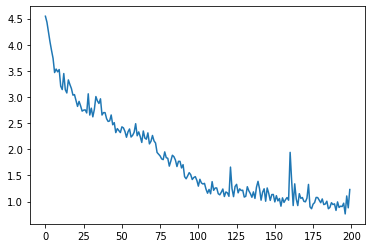

In [14]:
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [15]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0], data[1]
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network: ',  (100 * right / counter))

Accuracy of the network:  77.81954887218045


# Вывод:

При __уменьшении__ числа lstm слоев: 
+ Точность модели повышается быстрее на каждой итерации
- Дисперсия точности на каждой итерации так же возрастает
+ Скорость обучения повышается

При __увеличении__ числа lstm слоев:
- Точность модели повышается более плавно
+ Дисперсия точности на каждой итерации сглаживается
- Скорость обучения падает

При __уменьшении__ числа кадров:
+ Скорость обучения повышается
- Падает точность

При __увелчении__ числа кадров:
- Скорость обучения падает
- Точность сильно возрастает

2.	Дополнительное задание:<br>
a.	http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption - 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). Проделайте весь путь подготовки данных, создания датасета, разделения и обучения модели самостоятельно. Предсказывать нужно Global_active_power. Обратите внимание, что здесь задача регрессии, а не классификации, т.е. модель нужно изменить.